# Prob. Regression

In [2]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import tensorflow.compat.v2 as tf
# tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

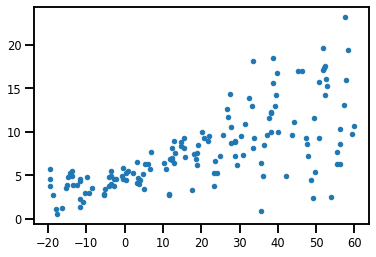

In [11]:
plt.figure()
plt.plot(x, y, '.');

In [36]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=lambda y, rv_y: -rv_y.log_prob(y))
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13006423
5.123336


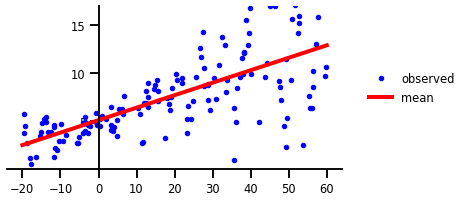

In [37]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 3])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

## Adding uncertainty bounds

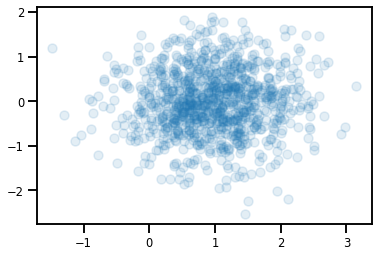

In [32]:
t = tf.constant([[1.,0.],[0.,1.]])
Normal = tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))
data = Normal.sample(1000)
plt.scatter(data[:,0], data[:, 1], alpha=0.12)

In [43]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=lambda y, rv_y: -rv_y.log_prob(y))
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.12513314 0.92246807]
[5.1901693 2.6918147]


In [46]:
# print(yhat.stddev())
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
 distribution_lambda_5 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


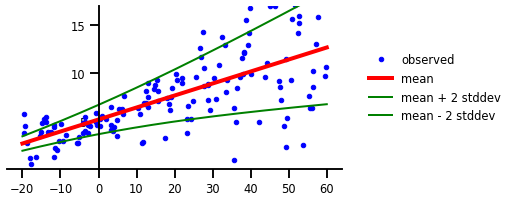

In [47]:
plt.figure(figsize=[6, 3])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

## Gaussian process regression

From [tfp Gaussian proc regression tutorial](https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb#scrollTo=n4-qQf7qZLVI)

Let $\mathcal{X}$ be any set. A *Gaussian process*
(GP) is a collection of random variables indexed by $\mathcal{X}$ such that if
$\{X_1, \ldots, X_n\} \subset \mathcal{X}$ is any finite subset, the marginal density
$p(X_1 = x_1, \ldots, X_n = x_n)$ is multivariate Gaussian. Any Gaussian
distribution is completely specified by its first and second central moments
(mean and covariance), and GP's are no exception. We can specify a GP completely
in terms of its mean function $\mu : \mathcal{X} \to \mathbb{R}$ and covariance function
$k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$. Most of the expressive power of GP's is encapsulated
in the choice of covariance function. For various reasons, the covariance
function is also referred to as a *kernel function*. It is required only to be
symmetric and positive-definite (see [Ch. 4 of Rasmussen & Williams](
http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)). Below we make use of the
ExponentiatedQuadratic covariance kernel. Its form is

$$
k(x, x') := \sigma^2 \exp \left( \frac{\|x - x'\|^2}{\lambda^2} \right)
$$

where $\sigma^2$ is called the 'amplitude' and $\lambda$ the *length scale*.
The kernel parameters can be selected via a maximum likelihood optimization
procedure.

A full sample from a GP comprises a real-valued function over the entire space
$\mathcal{X}$ and is in practice impractical to realize; often one chooses a set of
points at which to observe a sample and draws function values at these points.
This is achieved by sampling from an appropriate (finite-dimensional)
multi-variate Gaussian.

Note that, according to the above definition, any finite-dimensional
multivariate Gaussian distribution is also a Gaussian process. Usually, when
one refers to a GP, it is implicit that the index set is some $\mathbb{R}^n$
and we will indeed make this assumption here.

A common application of Gaussian processes in machine learning is Gaussian
process regression. The idea is that we wish to estimate an unknown function
given noisy observations $\{y_1, \ldots, y_N\}$ of the function at a finite
number of points $\{x_1, \ldots x_N\}.$ We imagine a generative process

$$
\begin{align}
f \sim \: & \textsf{GaussianProcess}\left(
    \text{mean_fn}=\mu(x),
    \text{covariance_fn}=k(x, x')\right) \\
y_i \sim \: & \textsf{Normal}\left(
    \text{loc}=f(x_i),
    \text{scale}=\sigma\right), i = 1, \ldots, N
\end{align}
$$

As noted above, the sampled function is impossible to compute, since we would
require its value at an infinite number of points. Instead, one considers a
finite sample from a multivariate Gaussian.

$$
  \begin{gather}
    \begin{bmatrix}
      f(x_1) \\
      \vdots \\
      f(x_N)
    \end{bmatrix}
    \sim
    \textsf{MultivariateNormal} \left( \:
      \text{loc}=
      \begin{bmatrix}
        \mu(x_1) \\
        \vdots \\
        \mu(x_N)
      \end{bmatrix} \:,\:
      \text{scale}=
      \begin{bmatrix}
        k(x_1, x_1) & \cdots & k(x_1, x_N) \\
        \vdots & \ddots & \vdots \\
        k(x_N, x_1) & \cdots & k(x_N, x_N) \\
      \end{bmatrix}^{1/2}
    \: \right)
  \end{gather} \\
  y_i \sim \textsf{Normal} \left(
      \text{loc}=f(x_i),
      \text{scale}=\sigma
  \right)
$$

Note the exponent $\frac{1}{2}$ on the covariance matrix: this denotes a
Cholesky decomposition. Comptuing the Cholesky is necessary because the MVN is
a location-scale family distribution. Unfortunately the Cholesky decomposition
is computationally expensive, taking $O(N^3)$ time and $O(N^2)$ space. Much of
the GP literature is focused on dealing with this seemingly innocuous little
exponent.

It is common to take the prior mean function to be constant, often zero. Also,
some notational conventions are convenient. One often writes $\mathbf{f}$ for the
finite vector of sampled function values. A number of interesting notations are
used for the covariance matrix resulting from the application of $k$ to pairs of
inputs. Following [(Quiñonero-Candela, 2005)][QuinoneroCandela2005], we note
that the components of the matrix are covariances of function values at
particular input points. Thus we can denote the covariance matrix as $K_{AB}$
where $A$ and $B$ are some indicators of the collection of function values along
the given matrix dimensions.

[QuinoneroCandela2005]: http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf

For example, given observed data $(\mathbf{x}, \mathbf{y})$ with implied latent function
values $\mathbf{f}$, we can write

$$
K_{\mathbf{f},\mathbf{f}} = \begin{bmatrix}
  k(x_1, x_1) & \cdots & k(x_1, x_N) \\
  \vdots & \ddots & \vdots \\
  k(x_N, x_1) & \cdots & k(x_N, x_N) \\
\end{bmatrix}
$$

Similarly, we can mix sets of inputs, as in

$$
K_{\mathbf{f},*} = \begin{bmatrix}
  k(x_1, x^*_1) & \cdots & k(x_1, x^*_T) \\
  \vdots & \ddots & \vdots \\
  k(x_N, x^*_1) & \cdots & k(x_N, x^*_T) \\
\end{bmatrix}
$$

where we suppose there are $N$ training inputs, and $T$ test inputs. The above
generative process may then be written compactly as

$$
\begin{align}
\mathbf{f} \sim \: & \textsf{MultivariateNormal} \left(
        \text{loc}=\mathbf{0},
        \text{scale}=K_{\mathbf{f},\mathbf{f}}^{1/2}
    \right) \\
y_i \sim \: & \textsf{Normal} \left(
    \text{loc}=f_i,
    \text{scale}=\sigma \right), i = 1, \ldots, N
\end{align}
$$

The sampling operation in the first line yields a finite set of $N$ function
values from a multivariate Gaussian -- *not an entire function as in the above
GP draw notation*. The second line describes a collection of $N$ draws from
*univariate* Gaussians centered at the various function values, with fixed
observation noise $\sigma^2$.

With the above generative model in place, we can proceed to consider the
posterior inference problem. This yields a posterior distribution over function
values at a new set of test points, conditioned on the observed noisy data from
the process above.

With the above notation in place, we can compactly write the posterior
predictive distribution over future (noisy) observations conditional on
corresponding inputs and training data as follows (for more details, see §2.2 of
[Rasmussen & Williams](http://www.gaussianprocess.org/gpml/)). 

$$
\mathbf{y}^* \mid \mathbf{x}^*, \mathbf{x}, \mathbf{y} \sim \textsf{Normal} \left(
    \text{loc}=\mathbf{\mu}^*,
    \text{scale}=(\Sigma^*)^{1/2}
\right),
$$

where

$$
\mathbf{\mu}^* = K_{*,\mathbf{f}}\left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} \mathbf{y}
$$

and

$$
\Sigma^* = K_{*,*} - K_{*,\mathbf{f}}
    \left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} K_{\mathbf{f},*}
$$

In [48]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [49]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

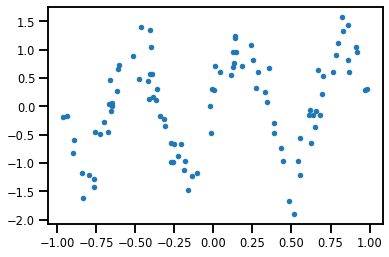

In [53]:
plt.plot(observation_index_points_, observations_, '.')

In [102]:
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})




In [95]:

x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=1.0700085346490633>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.2491013568888674>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.1588579298495019>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([ 0.58352862, -0.0680182 , -1.36972883, -0.75110152, -2.007989  ,
        0.65331403, -0.64801323,  1.62162951,  1.24752714,  0.63175607,
       -0.73647141, -0.02319663, -1.00879645, -0.990113  , -0.36125499,
        1.02183794, -1.47372276, -0.17812406,  0.89631135,  1.50312427,
        1.2367242 ,  0.95563158,  0.57390707,  0.08338687, -1.14908777,
       -0.95603563,  1.07577254, -1.48587769,  0.04549831, -0.87863842,
        1.45265324,  1.56880455, -0.19639854,  1.03528495,  0.84466965,
       -0.26391162,  0.66849519, -1.28647286, -0.10176222,  0.06395649,
        0.60643231, -1.08020834, -0.3567221 , -0.38121162,  0.3610271 ,
       -2.04750983, -0.99871

In [96]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

In [97]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [98]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.8102546765427235
length_scale: 0.1304865519543211
observation_noise_variance: 0.09384017388788018


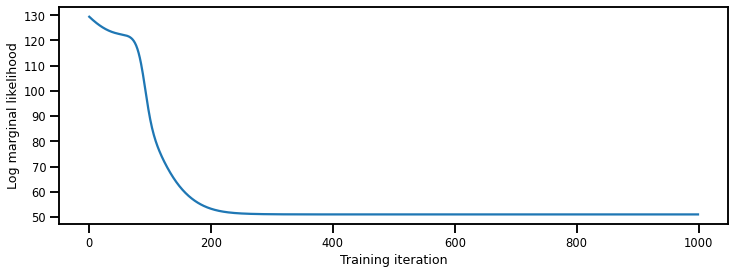

In [99]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [100]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

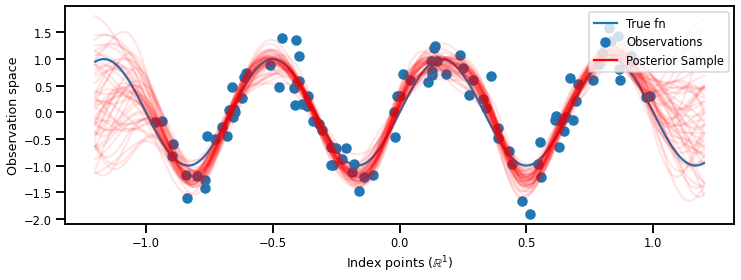

In [101]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()